# Feature Selection using Recursive Feature Elimination Model (RFE) using Random Forest, Gradient Boosting, Logistic Regression,  and SVM

In [6]:
import pandas as pd
import numpy as np

In [7]:
data = pd.read_csv("datasets/cicids2017.csv")
data.columns = data.columns.str.replace(' ', '')
data.shape

(286467, 79)

Dropping all rows with values near infinity

In [8]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)
data.shape


(286096, 79)

In [9]:
target = "Label"
x = data.loc[:, data.columns != target]
x.head()


,DestinationPort,FlowDuration,TotalFwdPackets,TotalBackwardPackets,TotalLengthofFwdPackets,TotalLengthofBwdPackets,FwdPacketLengthMax,FwdPacketLengthMin,FwdPacketLengthMean,FwdPacketLengthStd,...,act_data_pkt_fwd,min_seg_size_forward,ActiveMean,ActiveStd,ActiveMax,ActiveMin,IdleMean,IdleStd,IdleMax,IdleMin
0,22,1266342,41,44,2664,6954,456,0,64.975610,109.864573,...,24,32,0.0,0.0,0,0,0.0,0.0,0,0
1,22,1319353,41,44,2664,6954,456,0,64.975610,109.864573,...,24,32,0.0,0.0,0,0,0.0,0.0,0,0
2,22,160,1,1,0,0,0,0,0.000000,0.000000,...,0,32,0.0,0.0,0,0,0.0,0.0,0,0
3,22,1303488,41,42,2728,6634,456,0,66.536585,110.129945,...,24,32,0.0,0.0,0,0,0.0,0.0,0,0
4,35396,77,1,2,0,0,0,0,0.000000,0.000000,...,0,32,0.0,0.0,0,0,0.0,0.0,0,0


In [10]:
y = data[target]
y.value_counts()


PortScan    158804
BENIGN      127292
Name: Label, dtype: int64

In [11]:
y = pd.factorize(y)[0]
pd.value_counts(y)

1    158804
0    127292
dtype: int64

## PCA

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(x)
x = scaler.transform(x)

PCA should keep 95% of components that explains the variance


In [13]:
from sklearn.decomposition import PCA

pca = PCA(.9)
pca.fit(x)


PCA(n_components=0.9)

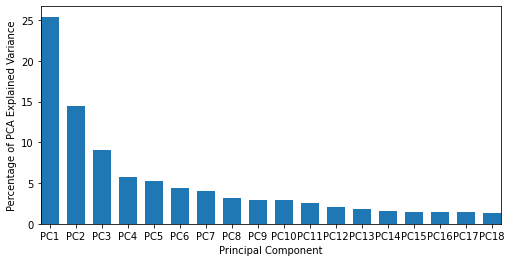

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
labels = ["PC" + str(x) for x in range(1, len(per_var) + 1)]
plt.bar(x=range(1, len(per_var) + 1), height=per_var,
        tick_label=labels, width=0.7,)

plt.ylabel("Percentage of PCA Explained Variance")
plt.xlabel("Principal Component")

plt.gca().margins(x=0)
plt.gcf().canvas.draw()
tl = plt.gca().get_xticklabels()
maxsize = max([t.get_window_extent().width for t in tl])
m = 0.1
s = maxsize/plt.gcf().dpi*len(per_var)+2*m
margin = m/plt.gcf().get_size_inches()[0]
plt.gcf().subplots_adjust(left=margin, right=1.-margin)
plt.gcf().set_size_inches(s, plt.gcf().get_size_inches()[1])

plt.savefig("images/explained pca variance.jpg", bbox_inches='tight')
plt.show()


In [10]:
pca_explained_variances = pd.DataFrame(
    dict(component=labels, percentage_of_explained_ratio=per_var))

pca_explained_variances.to_csv(
    "percentage of PCA Explained Variance.csv", index=False)
pca_explained_variances


,component,percentage_of_explained_ratio
0,PC1,25.4
1,PC2,14.4
2,PC3,9.1
3,PC4,5.8
4,PC5,5.2
5,PC6,4.4
6,PC7,4.0
7,PC8,3.2
8,PC9,2.9
9,PC10,2.9


In [14]:
from sklearn.model_selection import train_test_split

x = pca.transform(x)
x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.2, random_state=0)

## Classification Model Prediction

In [15]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.model_selection import cross_validate


def get_cross_validation_scores(estimator):
    scoring = ("accuracy", "f1", "recall", "precision",
               "roc_auc", "neg_mean_squared_error")
    scores = cross_validate(estimator, x, y, scoring=scoring, cv=10)
    return scores


def get_predictions(estimator):
    estimator.fit(x_train, y_train)
    prediction = estimator.predict(x_test)
    return prediction


def generate_scores(cv_dict, y_predicted, file_name):

    training_time = np.mean(cv_dict["fit_time"])
    prediction_time = np.mean(cv_dict["score_time"])
    accuracy = np.mean(cv_dict["test_accuracy"])
    f1 = np.mean(cv_dict["test_f1"])
    recall = np.mean(cv_dict["test_recall"])
    precision = np.mean(cv_dict["test_precision"])
    auc_roc = np.mean(cv_dict["test_roc_auc"])
    mean_squared_error = np.mean(cv_dict["test_neg_mean_squared_error"])

    fpr, tpr, thresholds = roc_curve(y_test, y_predicted, pos_label=1)
    auc_tr = auc(fpr, tpr)

    confusion_matrix_df = pd.crosstab(
        pd.Series(y_predicted, name="Predicted"), pd.Series(y_test, name="Actual"))

    TN, FP, FN, TP = confusion_matrix(y_test, y_predicted).ravel()
    percent_of_FP = (FP / (FP+TN)) * 100

    path = "./metrics/" + file_name + ".txt"

    with open(path, "w") as file:
        file.writelines([file_name,
                        "\n\nTraining Time:\t\t" + str(training_time),
                         "\nPrediction Time:\t" + str(prediction_time),
                         "\n\nAccuracy:    \t" + str(accuracy),
                         "\nF1:         \t" + str(f1),
                         "\nRecall:     \t" + str(recall),
                         "\nPrecision:  \t" + str(precision),
                         "\nAUC TR:     \t" + str(auc_tr),
                         "\nAUC ROC:    \t" + str(auc_roc),
                         "\nMean² Err:  \t" + str(mean_squared_error),
                         "\n\nConfusion Matrix\n",
                         confusion_matrix_df.to_string(),
                         "\n\nTN:\t" + str(TN),
                         "\nTP:\t" + str(TP),
                         "\nFN:\t" + str(FN),
                         "\nFP:\t" + str(FP),
                         "\n\nPecent of FP:\t%" + str(percent_of_FP),
                         ])

    with open(path, "r") as file:
        print(file.read())


def run(estimator, model_name):
    cv = get_cross_validation_scores(estimator)
    predictions = get_predictions(estimator)
    generate_scores(cv, predictions, model_name)


### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_jobs=-1, random_state=0)
run(rf, "Random Forest")


### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(n_jobs=-1, random_state=0)
run(dt, "Decision Tree")


### XGBoost

In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier(n_jobs=-1)
run(xgb, "XGBoost")

### SVM

In [ ]:
from sklearn.svm import SVC

svc = SVC()
run(svc, "SVM")


### Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
run(gnb, "Gaussian Naive Bayes")



### Logistic Regression


In [ ]:
from sklearn.linear_model import LogisticRegression

lg = LogisticRegression(n_jobs=-1, max_iter=1000)
run(lg, "Logistic Regression")


### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_jobs=-1)
run(knn, "KNN")